# Градиентные методы многомерной оптимизации

[К оглавлению примеров](_contents.ipynb)

In [1]:
# Начальная настройка рабочей среды. Запустите эту ячейку перед началом работы!
from plotutils import * # Функции для рисования поверхностей и контурных графиков
%matplotlib inline
#%matplotlib
from matplotlib import rcParams
rcParams.update({'font.size': 16})  # Крупнее шрифт для графиков
#rcParams.update({'font.family': 'Arial'}) # Если нет русского языка на графиках
import sympy as sp # Пакет символьной математики
sp.init_printing() # Включить отображение выражений sympy в виде математических формул
import scipy.optimize as so
%precision 4
1;

# Тестовые функции

## Параболическая функция с минимумом

Функция: $f(x, y) = x^2 + y^2 $

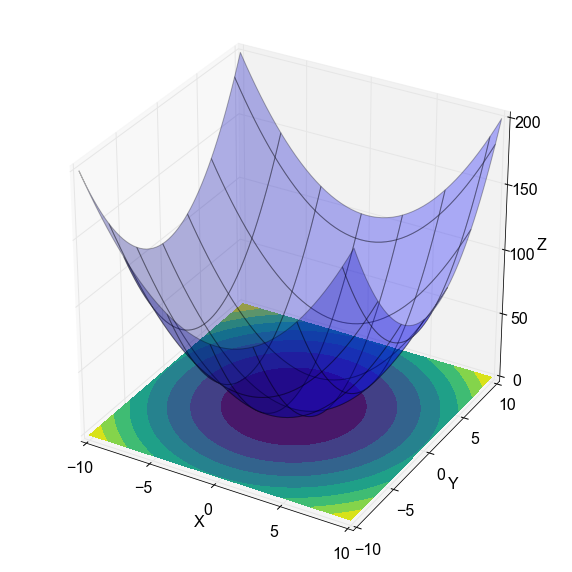

In [2]:
f = lambda x, y: x**2 + y**2
F = lambda X: f(X[0], X[1])
plotSurface(f)
plt.gcf().set_size_inches(10, 10)
#plt.savefig('parab2_surface.png', dpi=150)

Частные производные:

$$\frac{\partial f(x,y)}{\partial x} = 2x $$
$$\frac{\partial f(x,y)}{\partial y} = 2y $$

Градиент:

$$\nabla f(x,y) = 
\left[
\begin{array}[c]\\
        2 x \\
        2 y \\
\end{array}
\right]
$$

In [3]:
grad_f = lambda x, y: np.array([2*x, 2*y])
grad_F = lambda X: grad_f(X[0], X[1])

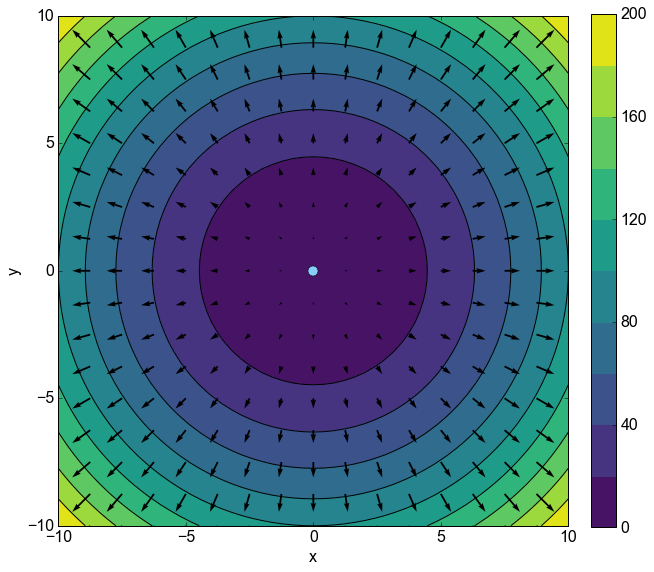

In [4]:
plotContours(f)
addGradients(grad_f, steps=17)
addPoint(0, 0)
#plt.savefig('parab2_gradients.png', dpi=150)

## Овражная функция

Функция: $k(x, y) = x^2 + 2 y^2 + x y$
Частные производные:

$$\frac{\partial f(x,y)}{\partial x} = 2x + y $$
$$\frac{\partial f(x,y)}{\partial y} = x + 4y $$

Градиент:

$$\nabla f(x,y) = 
\left[
\begin{array}\\
        2 x + y \\
        x + 4y \\
\end{array}
\right]
$$

In [5]:
k = lambda x, y: x**2 + 2 * y**2 + x * y
K = lambda X: k(X[0], X[1])

In [6]:
grad_k = lambda x, y: np.array([2 * x + y, x + 4 * y])
grad_K = lambda X: grad_k(X[0], X[1])

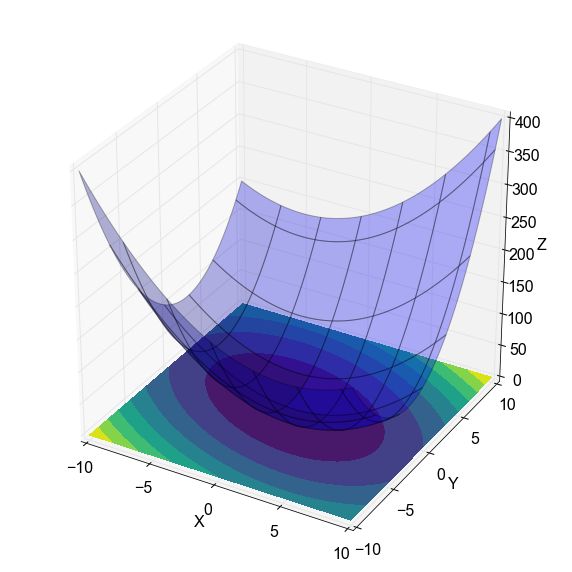

In [7]:
plotSurface(k)
plt.gcf().set_size_inches(10, 10)
#plt.savefig('interact_surface.png',dpi=150)

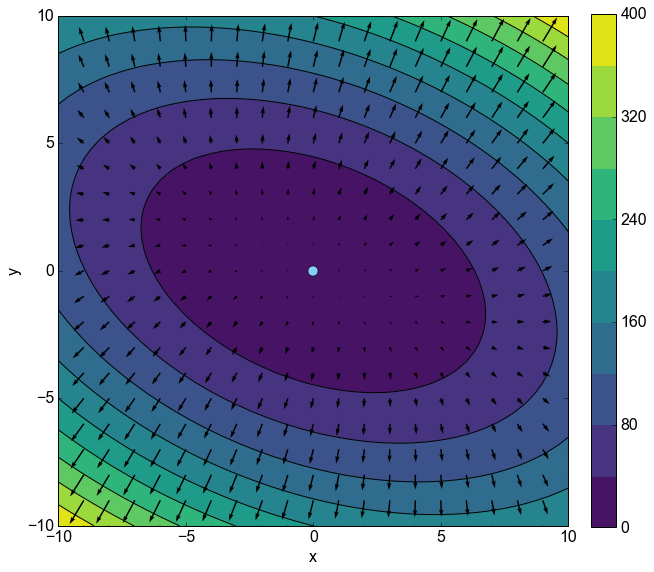

In [8]:
plotContours(k)
addGradients(grad_k)
addPoint(0, 0)
#plt.savefig('interact_gradients.png',dpi=150)

## Функция Розенброка

Функция Розенброка: $r(x, y) = 100(y - x^2)^2 + (1-x)^2 $

Стационарная точка (минимум) - $(1, 1)$

In [9]:
r = lambda x, y: 100 * (y - x**2)**2 + (1 - x)**2
R = lambda X: r(X[0], X[1])
x, y = sp.symbols('x, y')
rs = 100 * (y - x**2)**2 + (1 - x)**2
J_r = sp.Matrix([rs]).jacobian([x, y]).T
printMatrix(J_r)

<IPython.core.display.Math object>

In [10]:
grad_r = lambda x, y: np.array([
        -400 * x * (y - x**2) + 2 * x - 2, 
        200 * y - 200 * x**2
    ])

grad_R = lambda X: grad_r(X[0], X[1])

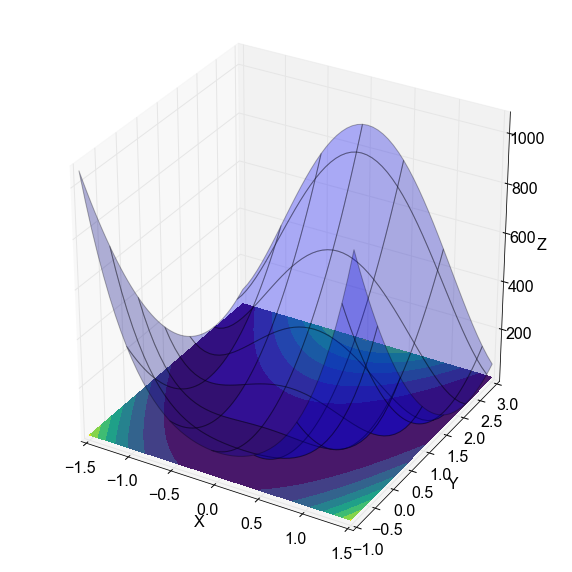

In [11]:
plotSurface(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
plt.gcf().set_size_inches(10, 10)

# Направление обзора и расстояние до наблюдателя
#plt.gca().view_init(elev=45, azim=-120)

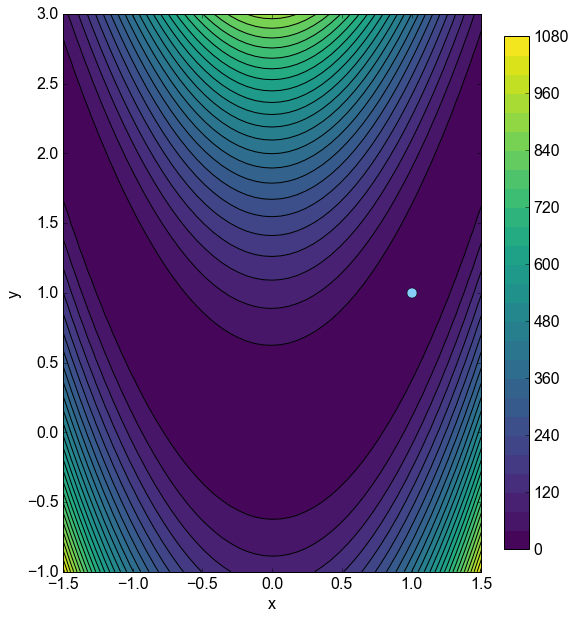

In [12]:
plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
addPoint(1, 1)
plt.gcf().set_size_inches(10, 10)

# Реализация градиентных методов

## Метод градиента

In [13]:
# Вспомогательная функция - аппроксимация градиента
def approximate_grad(f, X, delta=0.0005):
    """
    Аппроксимация градиента начальными конечными разностями
    
    Аргументы:
    f - функция (принимает векторный аргумент)
    X - точка для вычисления приближенного значения градиента (вектор)
    delta - шаг аппроксимации
    
    Возвращает: вектор градиента в точке X
    """
    
    X = X.astype('float64')
    grad = np.zeros_like(X, dtype='float64')
    
    for i in range(X.shape[0]):
        X2 = X.copy()
        X2[i] += delta
        grad[i] = (f(X2) - f(X)) / delta        
        
    return grad

In [14]:
# Метод градиентного спуска
def gradient_descent(f, X0, grad=None, alpha=1., eps=0.01, delta=0.0005, trace=False, path=False, max_steps=1000):
    """
    Минимизация функции многих переменных методом градиентного спуска.    
    
    Аргументы:
    f - функция для минимизации (функия принимает векторный аргумент)
    X0 - начальная точка (вектор)
    gradf - функция для вычисления градиента f в точке X
    alpha - начальный шаг поиска
    eps - точность локализации экстремума
    delta - шаг для аппроксимации градиента
    trace - нужно ли выводить шаги поиска
    path - нужно ли возаращать траекторию поиска        
    max_steps - максимальное число итераций (для предотвращения зацикливания)
    
    Возвращает кортеж: (x_min, f_min), если не требуется возвращать траекторию
    или кортеж: (x_min, f_min, path), где path - траектория (список словарей с результатами каждой итерации)
    """
    step = 0
    trajectory = []
    X0 = X0.astype('float64')
    
    # Если градиент не задан - задаем функцию для аппроксимации
    if grad is None: 
        grad = lambda X: approximate_grad(f, X, delta)        
    Xk = X0 # точка старта
    fk = f(Xk) # Вычисляем функцию в точке Xk
    if trace:
        print('%-3s %18s %18s %6s %6s %6s %6s' % 
              ('Шаг', 'Xk   ', 'Sk   ', '|grad|', 'alpha', 'fk  ', 'delta_f'))    
    while step < max_steps:
        step += 1
        grad_k = grad(Xk) # Вычисляем градиент в точке Xk
        norm_k = np.linalg.norm(grad_k) # Вычисляем модуль градиента        
        Sk = -1 * grad_k / norm_k # Вычисляем направление поиска в точке Xk
        Xnext = Xk + Sk * alpha # Вычисляем координату в следующей точке
        fnext = f(Xnext) # Вычисляем критерий в следующей точке
                
        if trace:
            print('%3d %18s %18s %6.3f %6.3f %6.3f %+6.3f' % 
                  (step, Xk, Sk, norm_k, alpha, fk, fnext - fk))        
        if path:            
            results = { 'step' : step,
                       'Xk' : Xk,
                       'grad_k' : grad_k,
                       'Sk' : Sk,
                       'alpha_k' : alpha,
                       'fk' : fk,
                       'Xnext' : Xnext,
                       'fnext' : fnext }
            trajectory.append(results)            
                
        if fnext > fk: # пролетели минимум: критерий увеличился
            alpha = alpha / 2
        else:
            if norm_k < eps : # выполнено условие остановки: модуль градиента близок к нулю
                #np.abs(fnext - fk) < eps : # выполнено условие остановки: критерий изменился слабо - выходим
                break

        fk = fnext
        Xk = Xnext
        
    if path:
        return Xk, fk, trajectory
    else:
        return Xk, fk
    

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [ 2.  2.]  [-0.7071 -0.7071]  5.657  1.000  8.000 -4.657
  2  [ 1.2929  1.2929]  [-0.7071 -0.7071]  3.657  1.000  3.343 -2.657
  3  [ 0.5858  0.5858]  [-0.7071 -0.7071]  1.657  1.000  0.686 -0.657
  4  [-0.1213 -0.1213]  [ 0.7071  0.7071]  0.343  1.000  0.029 +0.657
  5  [ 0.5858  0.5858]  [-0.7071 -0.7071]  1.657  0.500  0.686 -0.578
  6  [ 0.2322  0.2322]  [-0.7071 -0.7071]  0.657  0.500  0.108 -0.078
  7  [-0.1213 -0.1213]  [ 0.7071  0.7071]  0.343  0.500  0.029 +0.078
  8  [ 0.2322  0.2322]  [-0.7071 -0.7071]  0.657  0.250  0.108 -0.102
  9  [ 0.0555  0.0555]  [-0.7071 -0.7071]  0.157  0.250  0.006 +0.023
 10  [-0.1213 -0.1213]  [ 0.7071  0.7071]  0.343  0.125  0.029 -0.027
 11  [-0.0329 -0.0329]  [ 0.7071  0.7071]  0.093  0.125  0.002 +0.004
 12  [ 0.0555  0.0555]  [-0.7071 -0.7071]  0.157  0.062  0.006 -0.006
 13  [ 0.0113  0.0113]  [-0.7071 -0.7071]  0.032  0.062  0.000 +0.002
 14  [-0.0329 -0.03

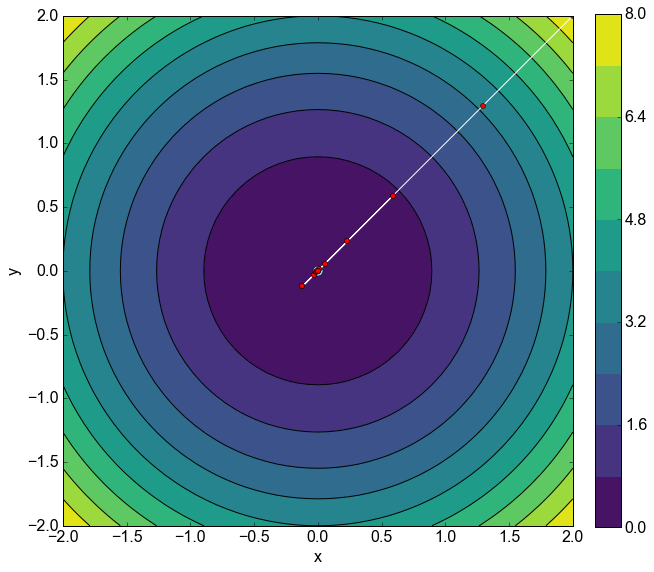

In [15]:
X_opt, f_opt, path = gradient_descent(F, np.array([2, 2]), grad_F, alpha=1, trace=True, path=True, eps=0.01)
plotContours(f, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path, points=True, search_dir=False)

In [16]:
X_opt, f_opt, path_gd = gradient_descent(K, np.array([2, 2]), grad_K, alpha=1, trace=True, path=True, eps=0.01)

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [ 2.  2.]  [-0.5145 -0.8575] 11.662  1.000 16.000 -9.485
  2  [ 1.4855  1.1425]  [-0.5619 -0.8272]  7.321  1.000  6.515 -5.171
  3  [ 0.9236  0.3153]  [-0.7035 -0.7107]  3.074  1.000  1.343 -1.069
  4  [ 0.2201 -0.3954]  [-0.0329  0.9995]  1.362  1.000  0.274 +0.604
  5  [ 0.1872  0.604 ]  [-0.3518 -0.9361]  2.781  0.500  0.878 -0.839
  6  [ 0.0113  0.136 ]  [-0.2746 -0.9615]  0.578  0.500  0.039 +0.258
  7  [-0.126  -0.3448]  [ 0.3686  0.9296]  1.619  0.250  0.297 -0.267
  8  [-0.0339 -0.1124]  [ 0.3492  0.9371]  0.516  0.250  0.030 +0.009
  9  [ 0.0534  0.1219]  [-0.3894 -0.9211]  0.587  0.125  0.039 -0.039
 10  [ 0.0047  0.0068]  [-0.4552 -0.8904]  0.036  0.125  0.000 +0.030
 11  [-0.0522 -0.1045]  [ 0.4058  0.9139]  0.515  0.062  0.030 -0.024
 12  [-0.0268 -0.0474]  [ 0.4228  0.9062]  0.239  0.062  0.006 -0.006
 13  [-0.0004  0.0092]  [-0.2267 -0.974 ]  0.038  0.062  0.000 +0.006
 14  [-0.0145 -0.05

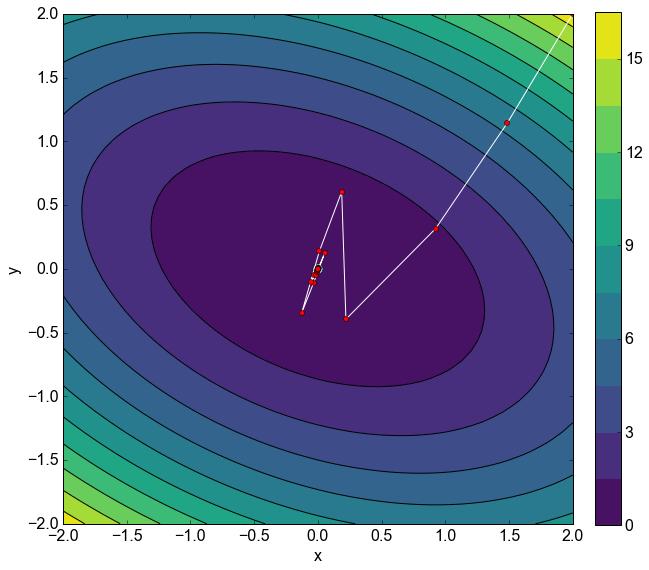

In [17]:
plotContours(k, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path_gd, points=True, search_dir=False)

In [18]:
X_opt, f_opt, path = gradient_descent(R, np.array([-1, 0]), grad_R, alpha=1, trace=False, path=True, max_steps=1000)

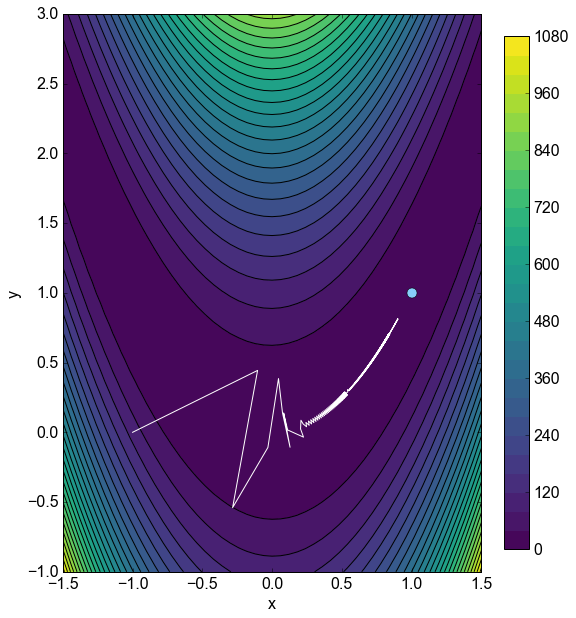

In [19]:
plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=False, search_dir=False)

## Метод наискорейшего спуска


In [20]:
# Метод градиентного спуска
def steepest_descent(f, X0, grad=None, eps=0.01, delta=0.0005, trace=False, path=False, max_steps=1000):
    """
    Минимизация функции многих переменных методом наискорейшего спуска    
    
    Аргументы:
    f - функция для минимизации (функия принимает векторный аргумент)
    X0 - начальная точка (вектор)
    gradf - функция для вычисления градиента f в точке X
    eps - точность локализации экстремума
    delta - шаг для аппроксимации градиента
    trace - нужно ли выводить шаги поиска
    path - нужно ли возаращать траекторию поиска        
    max_steps - максимальное число итераций (для предотвращения зацикливания)
    
    Возвращает кортеж: (x_min, f_min), если не требуется возвращать траекторию
    или кортеж: (x_min, f_min, path), где path - траектория (список словарей с результатами каждой итерации)
    """
    step = 0
    trajectory = []
    X0 = X0.astype('float64')
    
    # Если градиент не задан - задаем функцию для аппроксимации
    if grad is None: 
        grad = lambda X: approximate_grad(f, X, delta)        
    Xk = X0 # точка старта
    fk = f(Xk) # Вычисляем функцию в точке Xk
    if trace:
        print('%-3s %18s %18s %6s %6s %6s %6s' % 
              ('Шаг', 'Xk   ', 'Sk   ', '|grad|', 'alpha', 'fk  ', 'delta_f'))    
    while step < max_steps:
        step += 1
        grad_k = grad(Xk) # Вычисляем градиент в точке Xk
        norm_k = np.linalg.norm(grad_k) # Вычисляем модуль градиента        
        Sk = -1 * grad_k / norm_k # Вычисляем направление поиска в точке Xk
        
        # Вспомогательная функция - значение функции f в точке, заданной направлением и длиной шага
        g = lambda alpha : f(Xk + Sk * alpha)
        # Оптимальный шаг
        alpha = so.minimize_scalar(g).x
        
        Xnext = Xk + Sk * alpha # Вычисляем координату в следующей точке
        fnext = f(Xnext) # Вычисляем критерий в следующей точке
                
        if trace:
            print('%3d %18s %18s %6.3f %6.3f %6.3f %+6.3f' % 
                  (step, Xk, Sk, norm_k, alpha, fk, fnext - fk))        
        if path:            
            results = { 'step' : step,
                       'Xk' : Xk,
                       'grad_k' : grad_k,
                       'Sk' : Sk,
                       'alpha_k' : alpha,
                       'fk' : fk,
                       'Xnext' : Xnext,
                       'fnext' : fnext }
            trajectory.append(results)            
                
        if norm_k < eps : # выполнено условие остановки: модуль градиента близок к нулю
            #np.abs(fnext - fk) < eps : # выполнено условие остановки: критерий изменился слабо - выходим
            break

        fk = fnext
        Xk = Xnext
        
    if path:
        return Xk, fk, trajectory
    else:
        return Xk, fk
    

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [ 2.  2.]  [-0.7071 -0.7071]  5.657  2.828  8.000 -8.000
  2 [ -4.4409e-16  -4.4409e-16]  [ 0.7071  0.7071]  0.000  0.000  0.000 +0.000


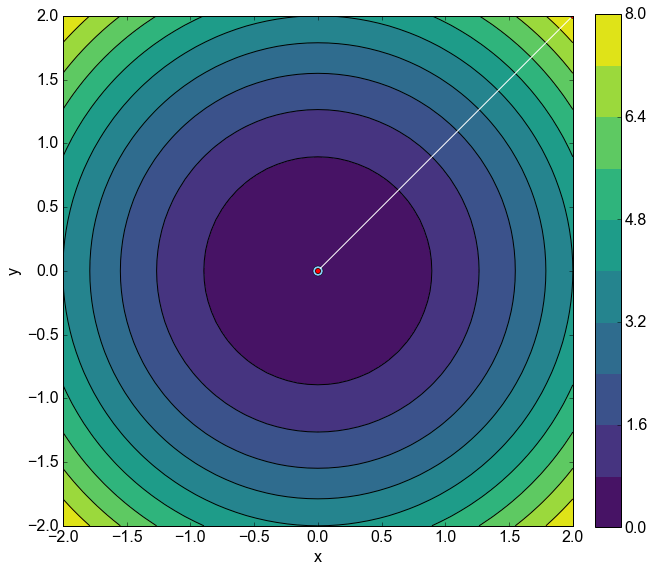

In [21]:
X_opt, f_opt, path = steepest_descent(F, np.array([2, 2]), grad_F, trace=True, path=True, eps=0.01)
plotContours(f, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path, points=True, search_dir=False)

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [ 2.  2.]  [-0.5145 -0.8575] 11.662  2.679 16.000 -15.622
  2  [ 0.6216 -0.2973]  [-0.8575  0.5145]  1.103  0.670  0.378 -0.369
  3  [ 0.0473  0.0473]  [-0.5145 -0.8575]  0.276  0.063  0.009 -0.009
  4  [ 0.0147 -0.007 ]  [-0.8575  0.5145]  0.026  0.016  0.000 -0.000
  5  [ 0.0011  0.0011]  [-0.5145 -0.8575]  0.007  0.001  0.000 -0.000


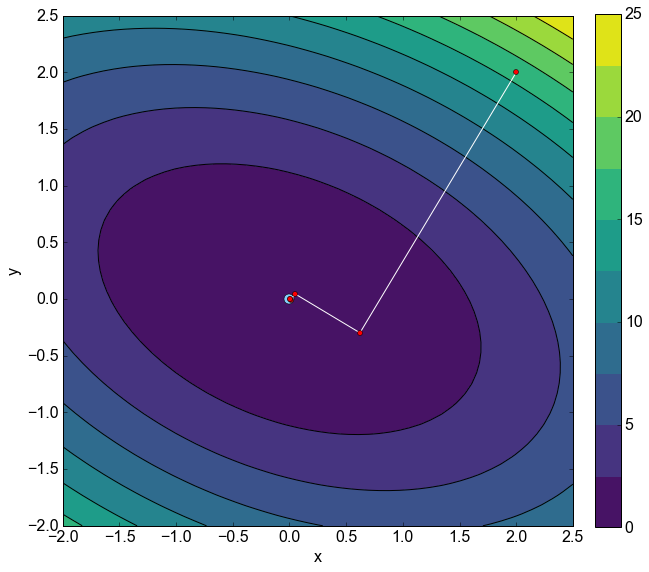

In [22]:
X_opt, f_opt, path = steepest_descent(K, np.array([2, 2]), grad_K, trace=True, path=True, eps=0.01)
plotContours(k, xlim=(-2, 2.5), ylim=(-2, 2.5))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path, points=True, search_dir=False)
#addPath(path_gd[:12], points=True, search_dir=False)
#plt.savefig('steepest_direction.png')

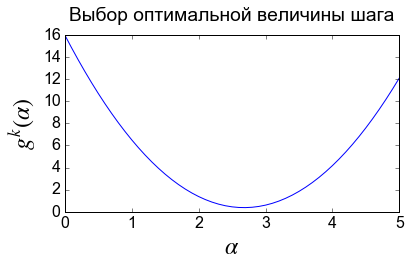

In [23]:
X1 = np.array([2, 2])
S1 = - grad_K(X1)
S1 = S1 / np.linalg.norm(S1)

@np.vectorize
def g1(alpha):
    return K(X1 + S1 * alpha)

alpha = np.linspace(0, 5, 51)
plt.plot(alpha, g1(alpha))
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$g^k(\alpha)$', fontsize=24)
plt.title('Выбор оптимальной величины шага', y=1.05)
plt.tight_layout();
#plt.savefig('alpha_opt.png')

In [24]:
X_opt, f_opt, path = steepest_descent(R, np.array([-1, 0]), grad_R, trace=False, path=True, max_steps=1500)

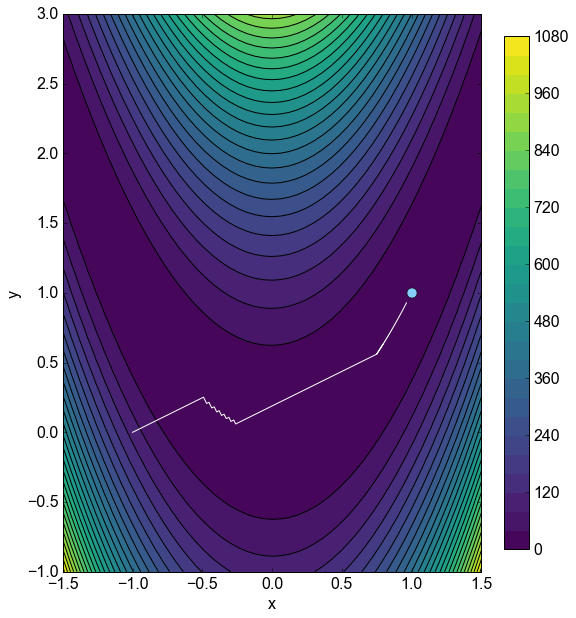

In [25]:
plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
addPoint(1, 1)
addPath(path, points=False, search_dir=False)
plt.gcf().set_size_inches(10, 10)
#plt.savefig('steepest_Rosenbrock.png')


## Метод сопряженных градиентов

In [26]:
# Метод сопряженных градиентов
def conjugate_gradients(f, X0, grad=None, eps=0.01, delta=0.0005, trace=False, path=False, max_steps=1000):
    """
    Минимизация функции многих переменных методом сопряженных градиентов
    
    Аргументы:
    f - функция для минимизации (функия принимает векторный аргумент)
    X0 - начальная точка (вектор)
    gradf - функция для вычисления градиента f в точке X
    eps - точность локализации экстремума
    delta - шаг для аппроксимации градиента
    trace - нужно ли выводить шаги поиска
    path - нужно ли возаращать траекторию поиска        
    max_steps - максимальное число итераций (для предотвращения зацикливания)
    
    Возвращает кортеж: (x_min, f_min), если не требуется возвращать траекторию
    или кортеж: (x_min, f_min, path), где path - траектория (список словарей с результатами каждой итерации)
    """
    step = 0
    trajectory = []
    X0 = X0.astype('float64')
    
    # Если градиент не задан - задаем функцию для аппроксимации
    if grad is None: 
        grad = lambda X: approximate_grad(f, X, delta)        
    Xk = X0 # точка старта
    fk = f(Xk) # Вычисляем функцию в точке Xk
    if trace:
        print('%-3s %18s %18s %6s %6s %6s %6s' % 
              ('Шаг', 'Xk   ', 'Sk   ', '|grad|', 'alpha', 'fk  ', 'delta_f'))    
    while step < max_steps:
        step += 1
        
        grad_k = grad(Xk) # Вычисляем градиент в точке Xk
        if step > 1: # Вычисляем линейную комбинацию градиентов на k и k-1 шаге
            grad_k = grad_k + grad_prev * grad_k.dot(grad_k) / grad_prev.dot(grad_prev)
            
        norm_k = np.linalg.norm(grad_k) # Вычисляем модуль градиента        
        Sk = -1 * grad_k / norm_k # Вычисляем направление поиска в точке Xk
        
        # Вспомогательная функция - значение функции f в точке, заданной направлением и длиной шага
        g = lambda alpha : f(Xk + Sk * alpha)
        # Оптимальный шаг
        alpha = so.minimize_scalar(g).x
        
        Xnext = Xk + Sk * alpha # Вычисляем координату в следующей точке
        fnext = f(Xnext) # Вычисляем критерий в следующей точке
                
        if trace:
            print('%3d %18s %18s %6.3f %6.3f %6.3f %+6.3f' % 
                  (step, Xk, Sk, norm_k, alpha, fk, fnext - fk))        
        if path:            
            results = { 'step' : step,
                       'Xk' : Xk,
                       'grad_k' : grad_k,
                       'Sk' : Sk,
                       'alpha_k' : alpha,
                       'fk' : fk,
                       'Xnext' : Xnext,
                       'fnext' : fnext }
            trajectory.append(results)            
                
        if fnext > fk: # пролетели минимум: критерий увеличился
            alpha = alpha / 2
        else:
            if norm_k < eps : # выполнено условие остановки: модуль градиента близок к нулю
                #np.abs(fnext - fk) < eps : # выполнено условие остановки: критерий изменился слабо - выходим
                break

        fk = fnext
        Xk = Xnext
        grad_prev = grad_k
        
    if path:
        return Xk, fk, trajectory
    else:
        return Xk, fk

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [ 2.  2.]  [-0.7071 -0.7071]  5.657  2.828  8.000 -8.000
  2 [ -4.4409e-16  -4.4409e-16]  [ 0.7071  0.7071]  0.000  0.000  0.000 +0.000


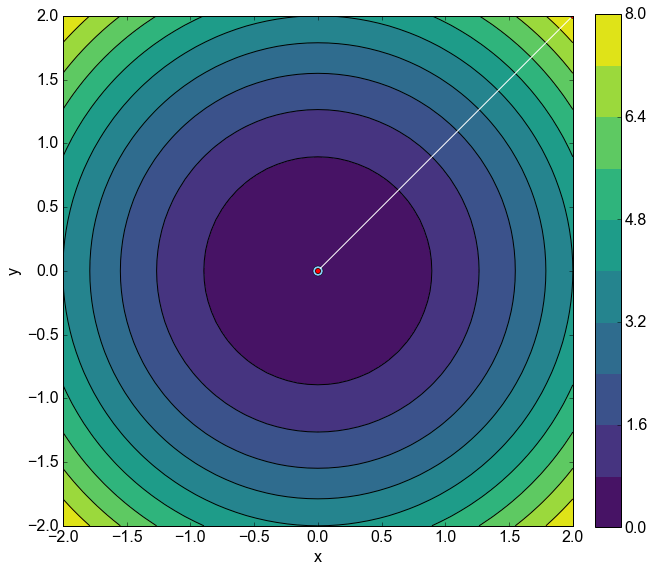

In [27]:
X_opt, f_opt, path = conjugate_gradients(F, np.array([2, 2]), grad_F, trace=True, path=True, eps=0.01)
plotContours(f, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path, points=True, search_dir=False)

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [ 2.  2.]  [-0.5145 -0.8575] 11.662  2.679 16.000 -15.622
  2  [ 0.6216 -0.2973]  [-0.9021  0.4315]  1.108  0.689  0.378 -0.378
  3 [ -3.3307e-16  -4.9960e-16]  [ 0.4472  0.8944]  0.000  0.000  0.000 +0.000


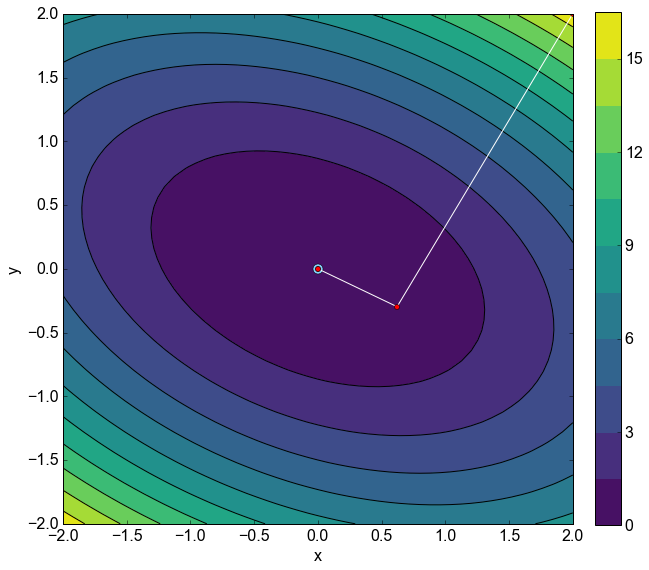

In [28]:
X_opt, f_opt, path = conjugate_gradients(K, np.array([2, 2]), grad_K, trace=True, path=True, eps=0.01)
plotContours(k, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)

addPath(path, points=True, search_dir=False)

Шаг              Xk                 Sk    |grad|  alpha   fk   delta_f
  1          [-1.  0.]  [ 0.8962  0.4437] 450.795  0.567 104.000 -101.765
  2  [-0.4915  0.2517]  [ 0.4481 -0.894 ]  2.252  0.052  2.235 -0.059
  3  [-0.4684  0.2055]  [ 0.7266 -0.687 ] 18.125  0.218  2.175 -0.297
  4  [-0.3102  0.0559]  [ 0.9653  0.2612] 13.001  0.881  1.879 -1.664
  5  [ 0.5401  0.286 ]  [-0.1732  0.9849]  1.182  0.004  0.215 -0.003
  6  [ 0.5394  0.2902]  [ 0.7241  0.6897]  0.944  0.098  0.212 -0.039
  7  [ 0.61    0.3575]  [ 0.5475  0.8368] 17.643  0.499  0.173 -0.157
  8  [ 0.883   0.7747]  [-0.7769  0.6296]  1.808  0.002  0.016 -0.002
  9  [ 0.8812  0.7761]  [ 0.5773  0.8165]  0.119  0.013  0.014 -0.001
 10  [ 0.8886  0.7865]  [ 0.4829  0.8757]  9.569  0.135  0.013 -0.009
 11  [ 0.9536  0.9044]  [-0.7552  0.6555]  2.095  0.002  0.005 -0.002
 12  [ 0.9519  0.9059]  [ 0.6388  0.7694]  0.046  0.001  0.002 -0.000
 13  [ 0.9526  0.9068]  [ 0.461   0.8874]  0.999  0.085  0.002 -0.002
 14  [ 0.9917  

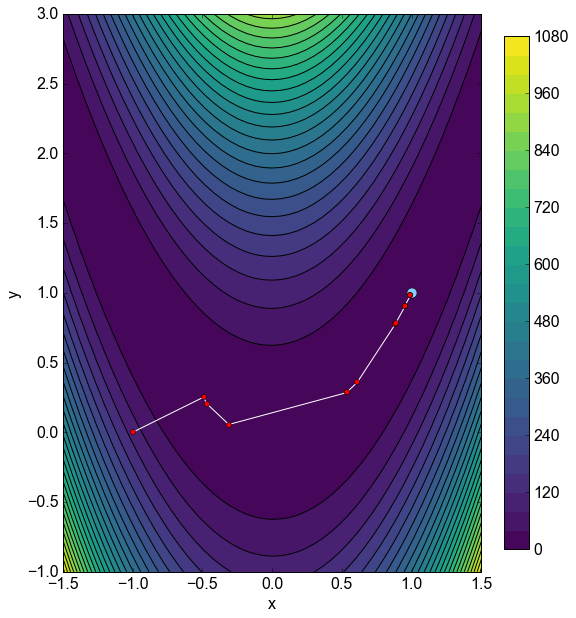

In [29]:
X_opt, f_opt, path = conjugate_gradients(R, np.array([-1, 0]), grad_R, trace=True, path=True, max_steps=1500)
plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=True, search_dir=False)
#plt.savefig('conjugate_gradients.png')

# Использование пакета `scipy.optimize`

Для минимизации многомерных функций в пакете `scipy.optimize` содержится функция `minimize()`. Чтобы ей воспользоваться, необходимо задать минимизируемую функцию (должна принимать векторный аргумент) и указать начальное приближение. Функция повзоляет выбрать применяемый метод, задав аргумент: `method=...`:   `'Nelder-Mead','Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'dogleg', 'trust-ncg'`

Некоторые методы требуют задать градиент (`jac=...`) и/или гессиан (`hess=`). В этом случае необходимо указать функции для их вычисления. Функция должна принимать векторный аргумент и возвращать одномерный массив (для градиента) или массив `n x n` (для гессиана).

In [30]:
# Функция R(X) - вычисляет функцию Розенброка в точке X (задана в разделе 2.3)
# Функция grad_R(X) - вычисляет градиент функции Розенброка в точке X (задана в разделе 2.3)

X0 = np.array([-1, 0])
# По умолчанию используется метод BFGS и численная аппроксимация градиента

res = so.minimize(R, X0)
print(res.x)
res

[ 1.  1.]


      nit: 20
 hess_inv: array([[ 0.4999,  0.9999],
       [ 0.9999,  2.0047]])
   status: 0
      jac: array([  3.9666e-06,  -1.9782e-06])
  message: 'Optimization terminated successfully.'
      fun: 2.0034669360545722e-11
     njev: 25
        x: array([ 1.,  1.])
  success: True
     nfev: 100

In [31]:
%%timeit
res = so.minimize(R, X0)

100 loops, best of 3: 2.99 ms per loop


In [32]:
# Метод сопряженных градиентов, численная аппроксимация градиента
res = so.minimize(R, X0, method='CG')
print(res.x)
res

[ 1.  1.]


     nit: 17
  status: 0
     jac: array([ -1.7426e-07,   8.6061e-08])
 message: 'Optimization terminated successfully.'
     fun: 2.006487215254125e-11
    njev: 38
       x: array([ 1.,  1.])
 success: True
    nfev: 152

In [33]:
%%timeit
res = so.minimize(R, X0, method='CG')

100 loops, best of 3: 2.71 ms per loop


In [34]:
# Метод сопряженных градиентов, градиент задан аналитически
res = so.minimize(R, X0, jac=grad_R, method='CG')
print(res.x)
res

[ 1.  1.]


     nit: 17
  status: 0
     jac: array([ -2.0878e-07,   1.0419e-07])
 message: 'Optimization terminated successfully.'
     fun: 2.7177778302601776e-17
    njev: 38
       x: array([ 1.,  1.])
 success: True
    nfev: 38

In [35]:
%%timeit
res = so.minimize(R, X0, jac=grad_R, method='CG')

1000 loops, best of 3: 1.94 ms per loop


Можно получить траекторию поиска, задав функцию, которая будет вызываться после каждой итерации

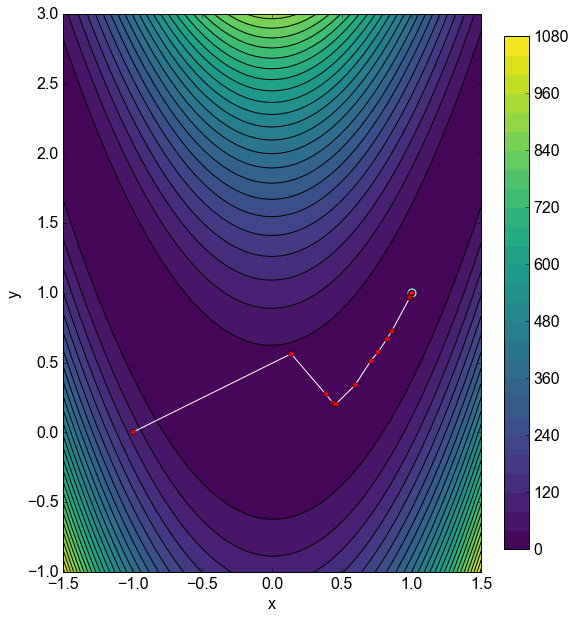

In [36]:
path = [{'Xk' : X0}] # список результатов содержит только начальную точку
def after_iter(X):
    result = {'Xk' : X, 'Xnext': X}
    path.append(result)
    
so.minimize(R, X0, jac=grad_R, method='CG', callback=after_iter);

plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=True)
#plt.savefig('conjugate_gradients.png')
